In [1]:
import apogee.tools.read as apread
from apogee.tools import _aspcapPixelLimits
from apogee.tools.path import change_dr
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as afits
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from apogee.tools import bitmask as bm
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
from gaia_tools import load as gload
from gaia_tools import xmatch as gmatch
import scipy.misc as sm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib.colors import LogNorm
default_cmap='viridis'
fs = 12
import matplotlib
font = {'family': 'serif',
        'weight': 'normal',
        'size'  :  fs
}

matplotlib.rc('font',**font)
def histogram2d(fig,ax,x,y,bins=100,clabel=False,vmin=0,vmax=110,norm='lin'):
    """
    Create a 2D histogram of data represented by the two dimensions x and y
    
    fig:      Figure to plot in
    ax:       Subplot object to plot in
    x:        Array of data values in 'x'
    y:        Array of data values in 'y'
    bins:     Number of bins in which to divide each axis
    clabel:   Label for the colourbar - no colourbar is plotted if this is not given
    vmin:     Minimum value of the histogram
    vmax:     Maximum value of the histogram
    
    """
    # Create histogram
    H,xedges,yedges = np.histogram2d(x,y,bins=bins)
    # Reorient appropriately
    H = np.rot90(H)
    H = np.flipud(H)
    # Mask where bins are empty
    Hmasked = np.ma.masked_where(H==0,H)
    # Plot histogram
    if norm == 'lin':
        im = ax.pcolormesh(xedges,yedges,Hmasked,
                           cmap = plt.get_cmap(default_cmap),
                           vmin=vmin,vmax=vmax)
    elif norm == 'log':
            im = ax.pcolormesh(xedges,yedges,Hmasked,
                           cmap = plt.get_cmap(default_cmap),
                           norm=LogNorm(vmin=vmin,vmax=vmax))
    # If colourbar is desired, plot and label it
    if clabel:
        cbar=fig.colorbar(im,pad = 0)
        cbar.set_label(label=clabel,fontsize=fs)
        cbar.ax.tick_params(labelsize=fs)
    elif not clabel:
        cbar=fig.colorbar(im,pad = 0)
        cbar.ax.tick_params(labelsize=fs)

In [3]:
change_dr('13')
pixels = _aspcapPixelLimits()[-1]

In [4]:
apogee_cat = apread.allStar(rmdups=True)

In [5]:
g2match, matches_indx= gmatch.cds(apogee_cat,xcat='vizier:I/345/gaia2') 
apogee_cat= apogee_cat[matches_indx] 

In [20]:
goodparallax = np.where((g2match['parallax_error']/g2match['parallax']<=0.1) & (g2match['parallax']>0))
g2 = g2match[goodparallax]
apo = apogee_cat[goodparallax]

/home/price-jones/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [21]:
c = SkyCoord(ra=g2['ra']*u.degree,dec=g2['dec']*u.degree,
             distance=(1./g2['parallax'])*u.kpc,frame='icrs')
cgal = c.galactocentric
cgal.representation_type = 'cylindrical'

In [96]:
def plot_trends(ax1,ax2,chem,ax1bins=[(0,1),(1,2),(2,4)],
                ax2bins=[(4,7),(7,8),(8,9),(9,10),(10,11),(11,13)],ax1name='z',
                ax2name='R',chemname='[Fe/H]'):
    colors = plt.get_cmap('copper')(np.linspace(0,1,len(ax1bins)))
    plt.figure(figsize=(15,6))
    for b1 in range(len(ax1bins)):
        members = (ax1 >= ax1bins[b1][0]) & (ax1 < ax1bins[b1][1])
        distvals = ax2[members]
        chemvals = chem[members]
        binnedarr = np.zeros(len(ax2bins))
        binnedval = np.zeros(len(ax2bins))
        binnedstd = np.zeros(len(ax2bins))
        for b2 in range(len(ax2bins)):
            binnedarr[b2] = ((ax2bins[b2][1]-ax2bins[b2][0])/2.)+ax2bins[b2][0]
            members = (distvals >= ax2bins[b2][0]) & (distvals < ax2bins[b2][1])
            binnedval[b2] = np.mean(chemvals[members])
            binnedstd[b2] = np.std(chemvals[members])
        plt.plot(binnedarr,binnedval,color=colors[b1],label='{0} < {1} < {2}'.format(ax1bins[b1][0],ax1name,ax1bins[b1][1]))
        print(binnedstd)
        plt.fill_between(binnedarr,binnedval-binnedstd,binnedval+binnedstd,color=colors[b1],alpha=0.5)
    plt.legend(loc='best')
    plt.xlabel(ax2name)
    plt.ylabel(chemname)

[ 0.26565382  0.25933048  0.22872628  0.20875011  0.19051994  0.17320947]
[ 0.30974993  0.30369803  0.30445015  0.26166871  0.24363005  0.21969101]
[ 0.35802299  0.32507789  0.34020826  0.30019161  0.30633938  0.28264543]


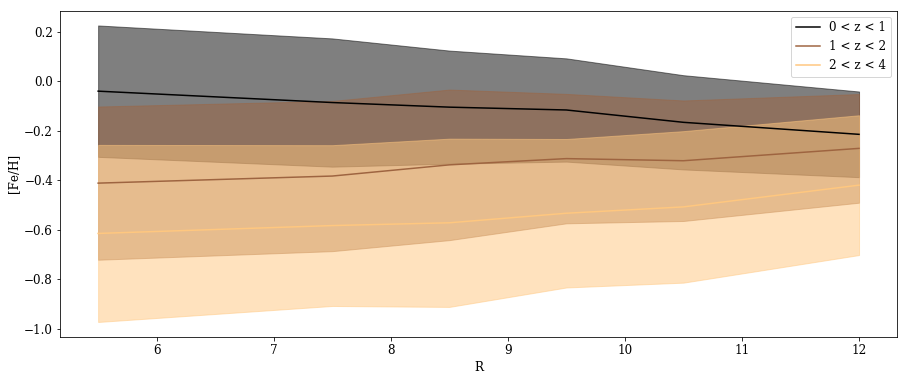

In [97]:
key = 'FE_H'
restrict = apo[key] > -1000
chem = apo[key][restrict]
R = (cgal.rho[restrict]).astype('float64')
z = (cgal.z[restrict]).astype('float64')
phi = (cgal.phi[restrict]).astype('float64')
plot_trends(np.fabs(z).value,R.value,chem)

[ 0.07237221  0.07401678  0.06878777  0.05256167  0.04723871  0.04002784]
[ 0.06867687  0.0785664   0.08351799  0.08027519  0.06867509  0.06292538]
[ 0.06427964  0.0650472   0.07886191  0.07697586  0.07944696  0.06710681]


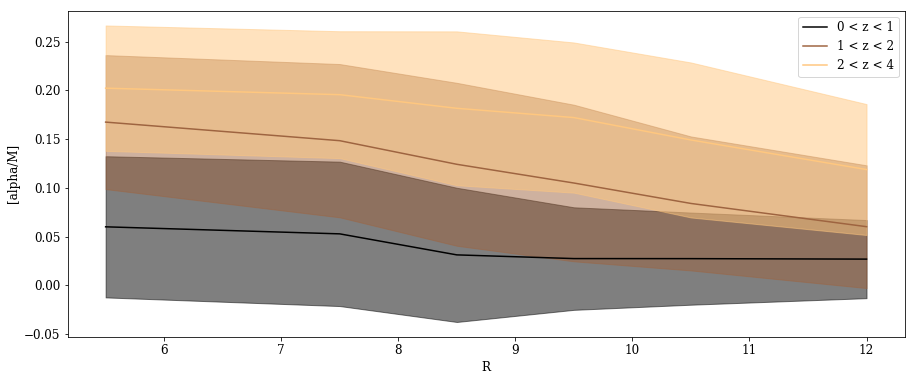

In [98]:
key = 'ALPHA_M'
restrict = apo[key] > -1000
chem = apo[key][restrict]
R = (cgal.rho[restrict]).astype('float64')
z = (cgal.z[restrict]).astype('float64')
phi = (cgal.phi[restrict]).astype('float64')
plot_trends(np.fabs(z).value,R.value,chem,chemname='[alpha/M]')

[  0.09586157   0.09595992  78.94078827   0.09883042   0.09757841
   0.10122033]
[ 0.09506046  0.10118496  0.10849993  0.09741006  0.10067759  0.08964444]
[  1.16904363e-01   3.74132782e+02   1.33275613e-01   1.25007004e-01
   1.29439369e-01   7.27519467e-02]


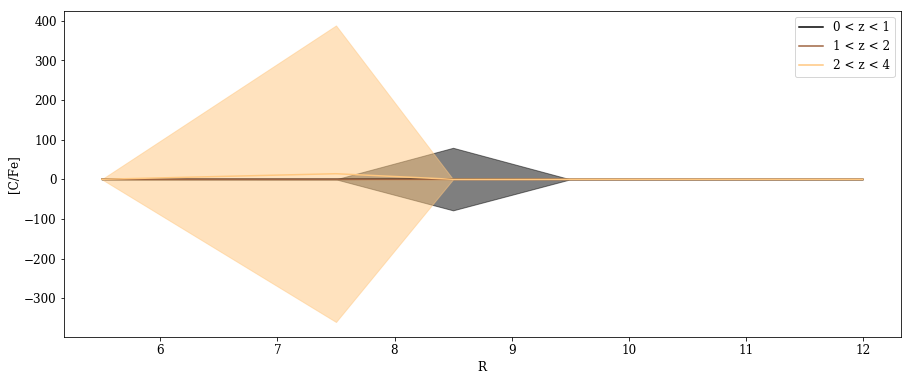

In [99]:
key = 'C_FE'
restrict = apo[key] > -1000
chem = apo[key][restrict]
R = (cgal.rho[restrict]).astype('float64')
z = (cgal.z[restrict]).astype('float64')
phi = (cgal.phi[restrict]).astype('float64')
plot_trends(np.fabs(z).value,R.value,chem,chemname='[C/Fe]')

[ 0.19680046  0.15912411  0.16614302  0.13832407  0.12557092  0.11402793]
[ 0.21477175  0.22306812  0.19337311  0.20114127  0.18613629  0.17365362]
[ 0.22813077  0.23195212  0.21554744  0.21525788  0.20297542  0.22594661]
[ 0.29735628  0.2860848   0.28357467  0.23717685  0.29283485  0.15341814]


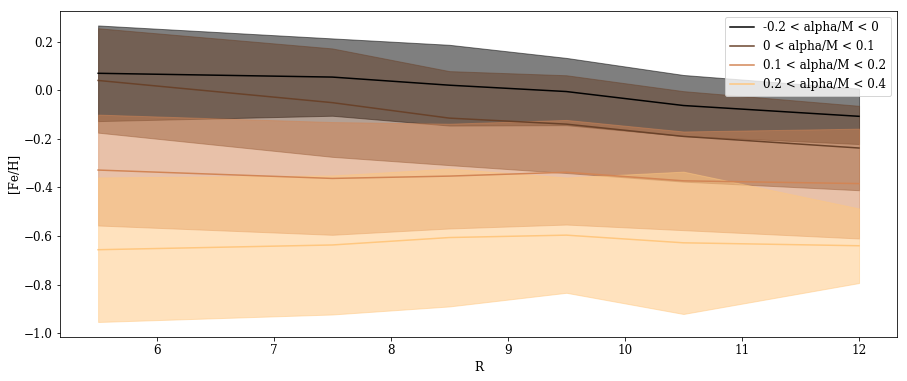

In [100]:
key = 'FE_H'
restrict = (apo[key] > -1000) & (apo['ALPHA_M']>-1000)
chem = apo[key][restrict]
R = (cgal.rho[restrict]).astype('float64')
z = (cgal.z[restrict]).astype('float64')
phi = (cgal.phi[restrict]).astype('float64')
plot_trends(apo['ALPHA_M'][restrict],R.value,chem,ax1name='alpha/M',chemname='[Fe/H]',ax1bins=[(-0.2,0),(0,0.1),(0.1,0.2),(0.2,0.4)])